# Web Scraping using *requests* library in Python

> *This notebook aims to explain the steps taken to scrape data from a live streaming channel on Twitch.tv, including viewer count, metadata about the streaming channel, advertising banners listed on the channel etc. To scrape data, the module* requests *was selected as it can handle a dynamic website such as Twitch*.

Multiple methods exist to extract data from websites, using modules such as *BeautifulSoup*, *requests*, *socket*, Twitch API ... .    
In practice, each of these modules allows for slighly different tasks. The library *requests* allows to send (POST) and receive (GET) data requests from HTML and FTP websites. The *BeautifulSoup* library can then be used to extract data from HTML websites and parse these into file respecting the logic and structure of HTML pages (eg *div*, *body*, *header* tags from HTML pages). However, some websites behave dynamically, sending and receiving data from a backend based on the user's behaviour. For these websites, *BeautifulSoup* could only capture the "squeleton" of the website, before backend data requests are made and are therefore unlikely to extract the required data. In this instance, the website needs to be "stimulated" for the backend data requests, using additional libraries such as *selenium*. An alternative is to use *requests* to stimulate the website, sending data requests and extracting the json data returned by the website. For websites containing data dynamically changing (e.g. chat logs), *socket* keeps the communication channel open to observe and extract any data change; this behaviour might be "overkill" if a user is only interested in a non-varying datapoint (a title) from a HTML page.
As for APIs made available by the website owner, these allow to obtain a range of data, but these data might not include what the user requires.

In this notebook, I used *requests* to extract metadata from streaming channels and viewer counts. Extracting required from chat logs was done using *socket*.

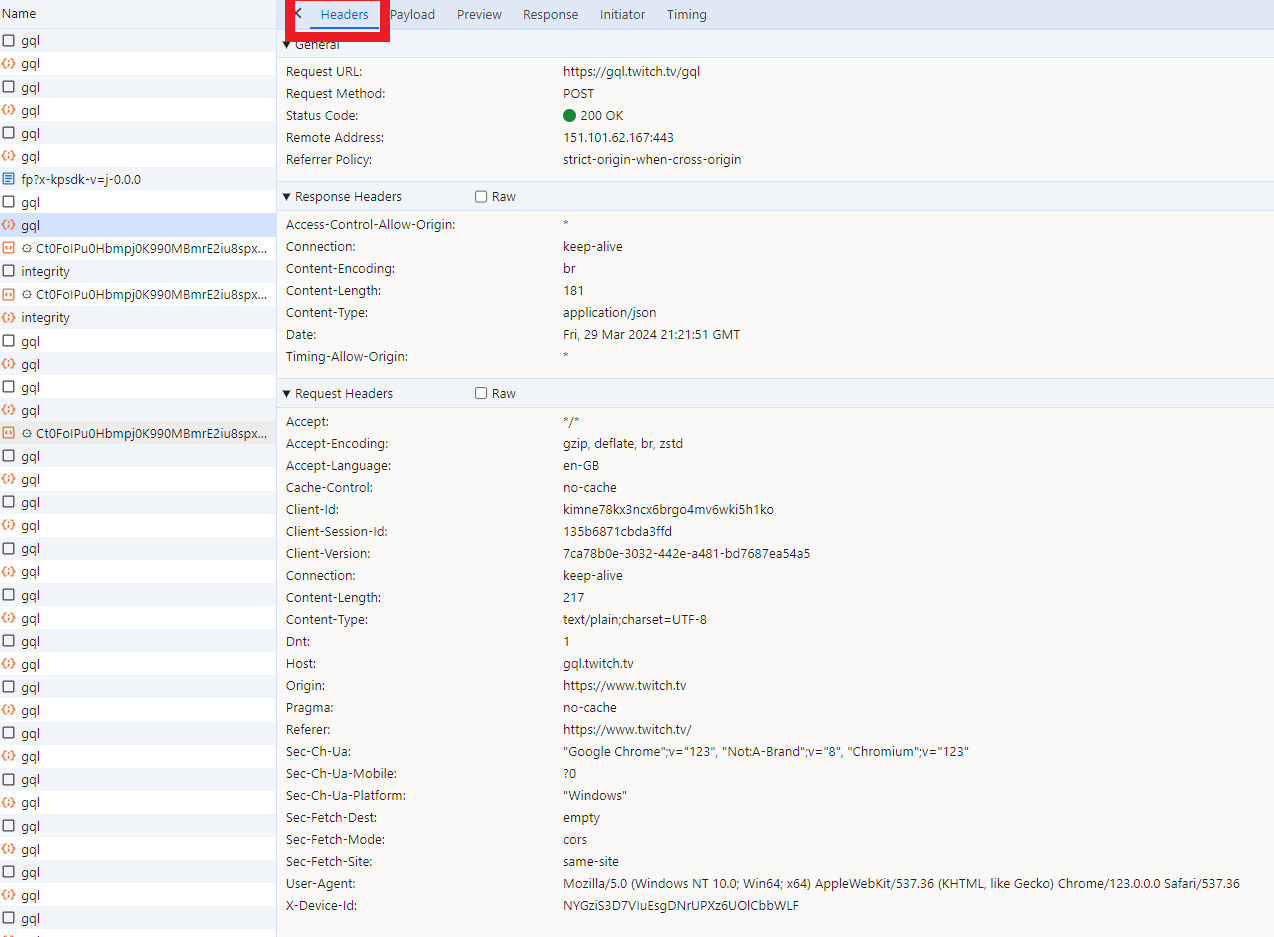

In [ ]:
%pip install brotli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.7 MB/s eta 0:00:00


In [ ]:
import requests as r
import pandas as pd
import numpy as np
import re #(regex to clean outputs)
from datetime import datetime
import plotly.graph_objects as go

from pprint import pprint
import brotli
import time
import json
import pytz

# Finding the right modules on HTML page

Using Chrome, load a streaming channel page (eg: CasinoDaddy on Twitch).
Right click, click on "inspect" to open the page settings.
Then click on "network" tab (red rectangle on the picture below). Click then on (green rectangles) "stop recording network", then "clear network log" to empty the log below. When done, make sure to tick the boxes "Preserve log" and "Disable Cache" (purple) if not ticked already.
Now, using the same previous buttons, reactivate the recording by clicking "record network" and refresh the page to reload it. This will basically re-send requests to the server and load all the elements required.

We are interested in the elements in the log named "gql" so filter these as shown on the picture (filter located under the green rectangle)

> refer to picture "casdaddy explain"

Look for the first gql appearing after you reload the page. Its the one showing up *after* one of the command with a red X next to it, meaning the command was stopped as you reloaded the page.   
Using "gql", the section headers give you all you need about "url_request" and "headers_request below.

> refer to picture "casdaddy header"



In [ ]:
# kkkk

### Defining required parameters to send/receive HTML requests

In [ ]:
### Define URL of interest

url_request = "https://gql.twitch.tv/gql"

url_request

'https://gql.twitch.tv/gql'

In [ ]:
### Define header

headers_request = """Accept: */*
Accept-Encoding: br
Accept-Language: en-US
Authorization: undefined
Cache-Control: no-cache
Client-ID: kimne78kx3ncx6brgo4mv6wki5h1ko
Connection: keep-alive
Content-Length: 713
Content-Type: text/plain; charset=UTF-8
Device-ID: 9blydZMjZvNIcW3E6zURCfIfuTJFPIVZ
DNT: 1
Host: gql.twitch.tv
Origin: https://www.twitch.tv
Pragma: no-cache
Referer: https://www.twitch.tv/
sec-ch-ua: "Not_A Brand";v="99", "Google Chrome";v="109", "Chromium";v="109"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "Windows"
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: cors
Sec-Fetch-Site: same-site
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"""

headers_request = dict(i.split(": ") for i in headers_request.split("\n"))
pprint(headers_request)

### Testing the formatting

print("\n" + "-" * 100 )
print("keys:\n ", headers_request.keys())

print("\n" + "-" * 100 )
print( "data type:\n", type(headers_request))


{'Accept': '*/*',
 'Accept-Encoding': 'br',
 'Accept-Language': 'en-US',
 'Authorization': 'undefined',
 'Cache-Control': 'no-cache',
 'Client-ID': 'kimne78kx3ncx6brgo4mv6wki5h1ko',
 'Connection': 'keep-alive',
 'Content-Length': '713',
 'Content-Type': 'text/plain; charset=UTF-8',
 'DNT': '1',
 'Device-ID': '9blydZMjZvNIcW3E6zURCfIfuTJFPIVZ',
 'Host': 'gql.twitch.tv',
 'Origin': 'https://www.twitch.tv',
 'Pragma': 'no-cache',
 'Referer': 'https://www.twitch.tv/',
 'Sec-Fetch-Dest': 'empty',
 'Sec-Fetch-Mode': 'cors',
 'Sec-Fetch-Site': 'same-site',
 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
 'sec-ch-ua': '"Not_A Brand";v="99", "Google Chrome";v="109", '
              '"Chromium";v="109"',
 'sec-ch-ua-mobile': '?0',
 'sec-ch-ua-platform': '"Windows"'}

----------------------------------------------------------------------------------------------------
keys:
  dict_keys(['Accept', 'A

Looking for the Json request can be found in "preview" (right side of headers) and from then on its a bit of a treasure hunt, looking for what you need.
For instance look for "viewersCount" and you will find the section that contains it. This would be the "response" to a request.
 To obtain the json request itself, go to the tab "payload" between "headers" and "preview", click on "view source" and there is your payload Json() request which we will use all along this notebook.   
 Happy Hunting !

 > refer to picture "casdaddy_previews"

In [ ]:
### Define the JSON request to be sent to the website
### Example


payload_request = [{"operationName":"UseViewCount",
        "variables":{"channelLogin":"casinodaddy"},
        "extensions":{
            "persistedQuery":{
                "version":1,
                "sha256Hash":"00b11c9c428f79ae228f30080a06ffd8226a1f068d6f52fbc057cbde66e994c2"
            }
        }
}]


#NB : sending just the dictionary {}, not contained within a list [], could also work. But for the sake of extracting data later, its preferable
# to contain it within a list.

print("JSON request to send to the website:\n")
pprint(payload_request)

JSON request to send to the website:

[{'extensions': {'persistedQuery': {'sha256Hash': '00b11c9c428f79ae228f30080a06ffd8226a1f068d6f52fbc057cbde66e994c2',
                                    'version': 1}},
  'operationName': 'UseViewCount',
  'variables': {'channelLogin': 'casinodaddy'}}]


In [ ]:
# Let us now the test the full request to the website

response_request = r.post(url      = url_request ,
                          headers  = headers_request ,
                          json     = payload_request
)

if(response_request.status_code == 200):
  print("Request successful")
else:
  print(f"Request failed ! Status code returned: {response_request.status_code}")


Request successful


Great ! The website did answer positively to our request expressed in the dictionary. Let us now look at what the website returned, and extract from it what we wish to get. The response is obtained using *.content or *.text but may be compressed (brotli, zip...) and/or encoded (eg utf-8), which requires some operation on it.

In [ ]:
print("Content and type for response.content:\n", response_request.content , "\nResponse type:\n", type(response_request.content))
print("-" * 100)
print("Content and type for response.text:\n", response_request.text , "\nResponse type:\n", type(response_request.text))
print("-" * 100)
print("Content and type for response.json:\n", response_request.json() , "\nResponse type:\n", type(response_request.json()))



Content and type for response.content:
 b'[{"data":{"user":{"id":"121228500","stream":{"id":"42158506872","viewersCount":1824,"__typename":"Stream"},"__typename":"User"}},"extensions":{"durationMilliseconds":39,"operationName":"UseViewCount","requestID":"01HT543DE5H27CXVFRECW2EDRE"}}]' 
Response type:
 <class 'bytes'>
----------------------------------------------------------------------------------------------------
Content and type for response.text:
 [{"data":{"user":{"id":"121228500","stream":{"id":"42158506872","viewersCount":1824,"__typename":"Stream"},"__typename":"User"}},"extensions":{"durationMilliseconds":39,"operationName":"UseViewCount","requestID":"01HT543DE5H27CXVFRECW2EDRE"}}] 
Response type:
 <class 'str'>
----------------------------------------------------------------------------------------------------
Content and type for response.json:
 [{'data': {'user': {'id': '121228500', 'stream': {'id': '42158506872', 'viewersCount': 1824, '__typename': 'Stream'}, '__typename

The response in the previous case was NOT compressed. If it was, the command response.content would not be readable. In the case it was compressed, the additional steps below may be required, namely checking the response headers to identify which compression or encoding was used, then decompress/decode accordingly.

In [ ]:
import brotli

# Check for "Content-Encoding" :
print("\n response headers:\n", response_request.headers)
print("-" * 50)

# if the Content-encoding shows "br" or "zip", its likely a decompression will be necessary.
response_content_dec = brotli.decompress(response_request.content)
print("response decompressed:\n", response_content_dec)

We have now all required steps to send requests and receive responses from the website, and know what to do in case of possible compression response. Let us now clean a bit the response and extract what we need, aka viewers_count which we saw previously appearing in "response.text".



In [ ]:
response_dict = response_request.json()
pprint(response_dict)
print("-" * 50)

# print("accessing Operation Name:")
#response_dict["extensions"] #["operationName"]

#name = dict()
named_data   = dict()
#cleaned_data = dict()

for i in response_dict:
  name = i["extensions"]["operationName"]
  named_data[name] = i["data"]

now = datetime.now(tz = pytz.timezone("Europe/London"))

print("\n" + "-"*50 + "\n")
print("keys for named_data: \n",*named_data.keys() )
print("\n" + "-"*50 + "\n")
print("values for named_data: \n",*named_data.values() )

print("\n" + "-"*50 + "\n")
print("values for Viewers_count: \n", named_data["UseViewCount"]["user"]["stream"]["viewersCount"] )

[{'data': {'user': {'__typename': 'User',
                    'id': '121228500',
                    'stream': {'__typename': 'Stream',
                               'id': '42158506872',
                               'viewersCount': 1824}}},
  'extensions': {'durationMilliseconds': 39,
                 'operationName': 'UseViewCount',
                 'requestID': '01HT543DE5H27CXVFRECW2EDRE'}}]
--------------------------------------------------

--------------------------------------------------

keys for named_data: 
 UseViewCount

--------------------------------------------------

values for named_data: 
 {'user': {'id': '121228500', 'stream': {'id': '42158506872', 'viewersCount': 1824, '__typename': 'Stream'}, '__typename': 'User'}}

--------------------------------------------------

values for Viewers_count: 
 1824


Alright ! So, as long as we know the operationsName in which our value of interest is nested, we can access it. We can now start to scale things up a bit...    
Let us review the information we may need :  
- viewer count
- few information about the streaming channel: name, number of followers, title of current stream, stream and user id ...
- word tags for the current streaming

and in which operationName json() placeholder I found these information hiding into :  
- *UseViewCount*
- *PlayerTrackingContextQuery*  
- *VideoPreviewOverlay*
- *StreamTagsTrackingChannel*
- *NielsenContentMetadata*
- *ChannelRoot_AboutPanel*   

The URL, headers do not change, but we need to generate the json request differently based on which specific information we are after. This is what we start with, and then we need to clean up the response and play with dictionaries to extract the info we want.

NB : Please note scraping data about the currently streaming chat will not be obtained here. Check my other notebook to this effect.


In [ ]:
def get_payload_json(name_of_the_channel,
                     get_counts         = True,
                     get_general_info   = False,
                     get_image_info     = False ,  #3
                     get_tags_info      = False ,
                     get_stream_info    = False ,
                     get_channel_info   = False ,  #6
                     #
                     get_ads_component_info = False ,
                     get_video_ad_info      = False ,
                     get_ad_request_info    = False  ,  #9
                     get_primeoffer_info    = False ,
                     get_pers_section_info  = False ,
                     get_age_gate_info      = False ,  # 12
                     get_nielsen_info       = False  ,
                     get_channel_shell_info = False ,
                     get_paid_chat_info     = False ,
                     get_channel_panel_info = False
):

  # TAG #1 : Viewer Count
  count_flag = {"operationName":"UseViewCount",
       "variables":{"channelLogin":name_of_the_channel},
       "extensions":{
           "persistedQuery":{
               "version"   : 1,
               "sha256Hash": "00b11c9c428f79ae228f30080a06ffd8226a1f068d6f52fbc057cbde66e994c2"
               }
       }
  }

  # TAG #2 : general info flag
  gen_info_flag = {"operationName":"PlayerTrackingContextQuery",
       "variables"    :{
          "channel":name_of_the_channel,
          "isLive": True  ,
          "hasCollection": False ,
          "collectionID":"",
          "videoID":"",
          "hasVideo": False ,
          "slug":"",
          "hasClip": False
      } ,
      "extensions"   :{
          "persistedQuery":{
                "version"   :1,
                "sha256Hash":"f8cf144bd3a96f628b0955799b689ddaf0d9f3f1155941ae6483083e421e3027"
            }
      }
  }

  # TAG #3 : image url for the streaming channel
  preview_image_flag = {
      "operationName":"VideoPreviewOverlay",
      "variables"    :{"login":name_of_the_channel},
      "extensions"   :{
          "persistedQuery":{
              "version"    : 1,
              "sha256Hash" :"9515480dee68a77e667cb19de634739d33f243572b007e98e67184b1a5d8369f"
          }
      }
  }


  # TAG #4 obtain keywords tagged to the currently streaming channel
  tags_flag = {
      "operationName":"StreamTagsTrackingChannel",
      "variables":{"channel":name_of_the_channel},
      "extensions":{
          "persistedQuery":
                {
               "version":1,
               "sha256Hash":"6aa3851aaaf88c320d514eb173563d430b28ed70fdaaf7eeef6ed4b812f48608"
            }
      }
  }

  # TAG #5 obtain stream info, including Title and Start date/time of the current streaming
  nielsen_content_flag = {"operationName":"NielsenContentMetadata",
                       "variables":{"isCollectionContent":False,
                                    "isLiveContent":True,
                                    "isVODContent":False,
                                    "collectionID":"",
                                    "login":name_of_the_channel,
                                    "vodID":""
                      },
                       "extensions":{"persistedQuery":{
                                        "version"   :1,
                                        "sha256Hash":"2dbf505ee929438369e68e72319d1106bb3c142e295332fac157c90638968586"}
                      }
  }



  # TAG 6 : obtain info about the channel (viewers)
  channel_info_flag = {"operationName":"ChannelRoot_AboutPanel",
                       "variables":{
                              "channelLogin" : name_of_the_channel,
                              "skipSchedule" : False
                       },
                       "extensions":{
                            "persistedQuery":{
                              "version"    :1,
                              "sha256Hash" :"6089531acef6c09ece01b440c41978f4c8dc60cb4fa0124c9a9d3f896709b6c6"
                            }
                       }
  }

  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS    # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS
    # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS

  ads_component_flag = {'extensions': {
                              'persistedQuery': {
                                        'sha256Hash': '1fd9eeac7ab98004ee00dc6554e88759f1fa66ea94b97487f69b1ddf3a9d215b',
                                        'version': 1
                              }
                          },
                        'operationName': 'Ads_Components_AdManager_User',
                        'variables': {}
  }


  video_ad_flag = {"operationName":"VideoAdBanner",
                   "variables":{
                          "input":{
                              "login"           :name_of_the_channel,
                              "ownsCollectionID":"",
                              "ownsVideoID":""
                          }
                  },
                   "extensions":{
                          "persistedQuery" :{
                                "version"   :1  ,
                                "sha256Hash":"4d9da3e74d52b668ad9f163a641236f2c804e1129f717f2861b362310e6c64c7"
                          }
                    }
  }

  ad_request_flag = { "operationName":"AdRequestHandling",
                      "variables":{
                            "isLive" : True,
                            "login"  : name_of_the_channel,
                            "isVOD"  : False,
                            "vodID"  : "",
                            "isCollection":False,
                            "collectionID":""
                      },
                      "extensions":{
                            "persistedQuery":{
                                  "version"   : 1,
                                  "sha256Hash":"61a5ecca6da3d924efa9dbde811e051b8a10cb6bd0fe22c372c2f4401f3e88d1"
                              }
                      }
  }


  primeoffer_flag = {"operationName":"Prime_PrimeOffers_CurrentUser",
                     "variables":{},
                     "extensions":{
                          "persistedQuery":{
                                  "version"   : 1 ,
                                  "sha256Hash":"a773b7efefe390d49753520f7db73d03794b008af6acc22c06a2c630d46d5518"
                          }
                      }
  }


  pers_section_flag =  {'operationName': 'PersonalSections',

                        'extensions': {'persistedQuery': {
                                          'sha256Hash': '1ad4a64ba2d092adc054604d66d3f4fb899ebddbcfcd931fee5796fa6bb597c0',
                                          'version': 1
                                        }
                        },

                        'variables': {'creatorAnniversariesFeature': False,
                                      'input': {
                                                'contextChannelName': name_of_the_channel ,
                                                'recommendationContext': {
                                                    'categorySlug': None,
                                                    'channelName': 'casinodaddy',
                                                    'clientApp': 'twilight',
                                                    'lastCategorySlug': None,
                                                    'lastChannelName': 'casinodaddy',
                                                    'pageviewContent': None,
                                                    'pageviewContentType': None,
                                                    'pageviewLocation': None,
                                                    'pageviewMedium': None,
                                                    'platform': 'web',
                                                    'previousPageviewContent': None,
                                                    'previousPageviewContentType': None,
                                                    'previousPageviewLocation': None,
                                                    'previousPageviewMedium': None
                                                },
                                      'sectionInputs': ['RECOMMENDED_SECTION',
                                            'SIMILAR_SECTION']
                                      }
                          }
  }


  channel_shell_flag =  {'operationName': 'ChannelShell', 'variables': {'login': name_of_the_channel} ,

                         'extensions': {
                              'persistedQuery': {
                                    'sha256Hash': '580ab410bcd0c1ad194224957ae2241e5d252b2c5173d8e0cce9d32d5bb14efe',
                                    'version'   : 1
                              }
                          }
  }


  # age_gate_flag = {'operationName': 'VideoPlayer_AgeGateOverlayBroadcaster',

  #                  'extensions': {
  #                         'persistedQuery': {
  #                               'sha256Hash'  : 'ab175a77fb908cd5dfe25d6d23da0765b3fc187e3d3461d1c7b157c354e917ee',
  #                                   'version' :  1
  #                         }
  #                  },

  #                 'variables': {'input': {
  #                                   'login'       : name_of_the_channel ,
  #                                   'ownsVideoID' : None
  #                                }
  #                               }
  # }


  # paid_chat_flag =  {'extensions': {
  #                             'persistedQuery': {
  #                                     'sha256Hash': 'ca9c6b5a43108f052eee866316e9cfd3455dce0544af6a14f7d1a917b9231e34',
  #                                     'version'   : 1
  #                             }
  #                     },
  #                   'operationName': 'PaidPinnedChat',
  #                   'variables'    : {
  #                           'channelID'  : '121228500',
  #                           'count'      : 25,
  #                           'messageType': 'CHEER'}
  # }


  channel_panel_flag = {"operationName"  :  "ChannelPanels",
                        "variables"      :{ "id":"121228500"},
                        "extensions":{
                            "persistedQuery":{
                                "version"   :1 ,
                                "sha256Hash":"c388999b5fcd8063deafc7f7ad32ebd1cce3d94953c20bf96cffeef643327322"
                            }
                        }
  }


  # for extra information about wildcards and regex, please check
  #       https://www.w3schools.com/python/python_regex.asp

  pre =[]

  #1
  if get_counts:
    pre.append(count_flag )

  if get_general_info:
    pre.append(gen_info_flag)

  #3
  if get_image_info:
    pre.append(preview_image_flag)

  if get_tags_info:
    pre.append(tags_flag)

  # 5
  if get_stream_info:
    pre.append(nielsen_content_flag)

  #
  if get_channel_info:
    pre.append(channel_info_flag)

  #   # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS  # EXTRA TAGS
  # 7
  if get_video_ad_info:
    pre.append(video_ad_flag)

  #
  if get_ad_request_info:
    pre.append(ad_request_flag)

  # #9
  if get_pers_section_info:
    pre.append(pers_section_flag)

  #
  if get_channel_shell_info:
    pre.append(channel_shell_flag)

  # #11
  if get_channel_panel_info:
    pre.append(channel_panel_flag)

  # COULD BE USEFUL LATER
  # #12
  # if get_ads_component_info:
  #   pre.append(ads_component_flag)

  # #13
  # if get_primeoffer_info:
  #   pre.append(primeoffer_flag)

  # #14
  # if get_age_gate_info:
  #   pre.append(age_gate_flag)

  # #15
  # if get_paid_chat_info:
  #   pre.append(paid_chat_flag)

  return pre

In [ ]:
### Lets test the creation of JSON() request

payload_json_request = get_payload_json(
                     name_of_the_channel = "casinodaddy" ,
                     get_counts         = False,
                     get_general_info   = False,
                     get_image_info     = False ,
                     get_tags_info      = False ,
                     get_stream_info    = False ,
                     get_channel_info   = False ,
                     #
                     get_video_ad_info      = True ,
                     get_ad_request_info    = True  ,
                     get_pers_section_info  = False ,
                     get_channel_panel_info = True ,
                     get_channel_shell_info = True ,
                     # get_age_gate_info      = False ,
                     # get_paid_chat_info     = False ,
                     # get_ads_component_info = False ,
                     # get_primeoffer_info    = False ,
)

pprint(payload_json_request)

In [ ]:
## ...  now lets use it as a request to the website ....

response_request = r.post(url      = url_request ,
                          headers  = headers_request ,
                          json     = payload_json_request
)

if(response_request.status_code == 200):
  print("Request successful")
else:
  print(f"Request failed ! Status code returned: {response_request.status_code}")

print("-"*50)

## ... and if all worked out, then spit out the response of the server (nb: depending on how many inputs were asked, this might be a long print...) :

#pprint(response_request.json())

for i in response_request.json():
  print(i["extensions"]["operationName"])
  pprint(i["data"])
  print("-" * 50)


In [ ]:
## Now to create the function that will "clean" the website response and extract the data we need

## Second function : clean the json() response from the server

def clean_a_bit(response_json : r.models.Response) -> pd.Series :

  # These lines below only valid IF Brotli decompression was returned by the server
  # response_content_dec = brotli.decompress(response_json.content)
  # json_string   = response_content_dec.decode('utf-8')
  # response_data = json.loads(json_string)


  # assuming that the "response_json" file will not be compressed :
  response_data = response_json.json()
  #pprint(response_data)


  named_data   = dict()
  cleaned_data = dict()

  for i in response_data:
    name = i["extensions"]["operationName"]
    named_data[name] = i["data"]
  now = datetime.now(tz = pytz.timezone("Europe/London"))
  now = now.strftime('%Y-%m-%d %H:%M:%S')


  # TAG #1 | Obtained info | viewers count at the moment of request
  if "UseViewCount" in named_data.keys():
    cleaned_data["current_viewers"]   = named_data["UseViewCount"]["user"]["stream"]["viewersCount"]


  # TAG #2 | Obtained info |
  if "PlayerTrackingContextQuery" in named_data.keys():
    cleaned_data["streamer_id"]    = named_data["PlayerTrackingContextQuery"]["user"]["id"]
    cleaned_data["streamer_login"] = named_data["PlayerTrackingContextQuery"]["user"]["login"]
    cleaned_data["game_id"]        = named_data["PlayerTrackingContextQuery"]["user"]["broadcastSettings"]["game"]["id"]
    cleaned_data["name"]           = named_data["PlayerTrackingContextQuery"]["user"]["broadcastSettings"]["game"]["name"]
      # cleaned_data["type"]           = named_data["PlayerTrackingContextQuery"]["user"]["broadcastSettings"]["game"]["__typename"]


  # TAG #3 | Obtained info | image URL
  if "VideoPreviewOverlay" in named_data.keys():
    cleaned_data["PreviewImage"]   = named_data["VideoPreviewOverlay"]["user"]["stream"]["previewImageURL"]


  # TAG #4 | Obtained info | tags associated to the currently streaming channel
  if "StreamTagsTrackingChannel" in named_data.keys():
    tag_box = named_data["StreamTagsTrackingChannel"]["user"]["stream"]["freeformTags"]
    tags_list = []
    [tags_list.append(i["name"]) for i in tag_box]
    cleaned_data["tags"]   = tags_list


  # TAG #5 | Obtained info | title and start date/time of currently streaming channel
  if "NielsenContentMetadata" in named_data.keys():
    cleaned_data["last_broadcast_title"] = named_data["NielsenContentMetadata"]["user"]["broadcastSettings"]["title"]
    cleaned_data["currented_created_at"] = named_data["NielsenContentMetadata"]["user"]["stream"]["createdAt"]


  # TAG #6 | Obtained info | Streaming Channel info
  if "ChannelRoot_AboutPanel" in named_data.keys():
    cleaned_data["nb_followers"] = named_data["ChannelRoot_AboutPanel"]["user"]["followers"]["totalCount"]

  # TAG #7 | Obtained info | Streaming Channel info
  if "VideoAdBanner" in named_data.keys():
    cleaned_data["Preview_vid_Image"] = named_data["VideoAdBanner"]["userByAttribute"]["profileImageURL"]

  # TAG # | Obtained info | Streaming Channel info
  if "AdRequestHandling" in named_data.keys():
    cleaned_data["is_mature"] = named_data["AdRequestHandling"]["user"]["broadcastSettings"]["isMature"]

  # # TAG #9 | Obtained info | Streaming Channel info
  # if "PersonalSections" in named_data.keys():
  #   cleaned_data["nb_followers"] = named_data["PersonalSections"]["user"]["followers"]["totalCount"]

  # TAG #10 | Obtained info | Streaming Channel info
  if "ChannelShell" in named_data.keys():
    cleaned_data["banner_img_url"]       = named_data["ChannelShell"]["userOrError"]["bannerImageURL"]
    cleaned_data["profile_img_url"]      = named_data["ChannelShell"]["userOrError"]["profileImageURL"]
    cleaned_data["stream_viewers_count"] = named_data["ChannelShell"]["userOrError"]["stream"]["viewersCount"]


  # TAG 11
  if "ChannelPanels" in named_data.keys():
    ads_panel_box = named_data["ChannelPanels"]["user"]["panels"]
    ads_list = []
    [ads_list.append(i["linkURL"]) for i in ads_panel_box]
    cleaned_data["ads_panel"]   = ads_list


  # POSSIBLY USEFUL FOR LATER
  # TAG #12 | Obtained info | Streaming Channel info
  # if "VideoPlayer_AgeGateOverlayBroadcaster" in named_data.keys():
  #   cleaned_data["nb_followers"] = named_data["VideoPlayer_AgeGateOverlayBroadcaster"][""][""][""]

  # TAG 13
  # if "PaidPinnedChat" in named_data.keys():
  #   cleaned_data["nb_followers"] = named_data["PaidPinnedChat"]["user"]["followers"]["totalCount"]

  # Aggregate everything collected from the channel into a dataframe
  series = pd.Series(cleaned_data)
  series["time"] = now

  return series.to_frame().T.set_index("time")



In [ ]:
payload_json_request = get_payload_json(
                     name_of_the_channel = "casinodaddy" ,
                     get_counts         = False,
                     get_general_info   = False,
                     get_image_info     = False ,
                     get_tags_info      = False ,
                     get_stream_info    = False ,
                     get_channel_info   = False ,
                     #
                     get_video_ad_info      = True ,
                     get_ad_request_info    = True  ,
                     get_pers_section_info  = False ,
                     get_channel_panel_info = True ,
                     get_channel_shell_info = True ,
                     # get_age_gate_info      = False ,
                     # get_paid_chat_info     = False ,
                     # get_ads_component_info = False ,
                     # get_primeoffer_info    = False ,
)


print("Payload request: \n ")
pprint(payload_json_request)
print("\n"+("-")*250+"\n")

response = r.post( url_request ,
                  headers = headers_request ,
                  json = payload_json_request )

print("Table with extracted data returned from the website:\n")
data_test = clean_a_bit( response_json = response )

data_test

#print(*data_test["ads_panel"])

Payload request: 
 
[{'extensions': {'persistedQuery': {'sha256Hash': '4d9da3e74d52b668ad9f163a641236f2c804e1129f717f2861b362310e6c64c7',
                                    'version': 1}},
  'operationName': 'VideoAdBanner',
  'variables': {'input': {'login': 'casinodaddy',
                          'ownsCollectionID': '',
                          'ownsVideoID': ''}}},
 {'extensions': {'persistedQuery': {'sha256Hash': '61a5ecca6da3d924efa9dbde811e051b8a10cb6bd0fe22c372c2f4401f3e88d1',
                                    'version': 1}},
  'operationName': 'AdRequestHandling',
  'variables': {'collectionID': '',
                'isCollection': False,
                'isLive': True,
                'isVOD': False,
                'login': 'casinodaddy',
                'vodID': ''}},
 {'extensions': {'persistedQuery': {'sha256Hash': '580ab410bcd0c1ad194224957ae2241e5d252b2c5173d8e0cce9d32d5bb14efe',
                                    'version': 1}},
  'operationName': 'ChannelShell',
 

Let us now define a wrapper to combine all functions into one callable in one line of code

In [ ]:
## define a function

def get_twitch_data(username,
             get_counts ,
             get_general_info   = False,
             get_image_info     = False ,
             get_tags_info      = False ,
             get_stream_info    = False ,
             get_channel_info   = False ,
             #
             get_video_ad_info      = False ,
             get_ad_request_info    = False  ,
             get_pers_section_info  = False ,
             get_channel_panel_info = False ,
             get_channel_shell_info = False ,
             **kwargs
):


  url = "https://gql.twitch.tv/gql"

  headers_request = """Accept: */*
Accept-Encoding: gzip, deflate, br
Accept-Language: en-US
Authorization: undefined
Cache-Control: no-cache
Client-ID: kimne78kx3ncx6brgo4mv6wki5h1ko
Connection: keep-alive
Content-Length: 713
Content-Type: text/plain; charset=UTF-8
Device-ID: 9blydZMjZvNIcW3E6zURCfIfuTJFPIVZ
DNT: 1
Host: gql.twitch.tv
Origin: https://www.twitch.tv
Pragma: no-cache
Referer: https://www.twitch.tv/{}
sec-ch-ua: "Not_A Brand";v="99", "Google Chrome";v="109", "Chromium";v="109"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "Windows"
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: cors
Sec-Fetch-Site: same-site
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36""".format(username)

  # print(headers_request)
  # print("\n\n")

  headers_request = dict( i.split(": ") for i in headers_request.split("\n") )
  #print(headers_request)
  # print("\n\n")

  payload_request_json = get_payload_json(
         username ,
         get_counts       = get_counts ,
         get_general_info   = get_general_info,
         get_image_info     = get_image_info ,
         get_tags_info      = get_tags_info ,
         get_stream_info    = get_stream_info ,
         get_channel_info   = get_channel_info ,
         #
         get_video_ad_info      = get_video_ad_info ,
         get_ad_request_info    = get_ad_request_info  ,
         get_pers_section_info  = get_pers_section_info ,
         get_channel_panel_info = get_channel_panel_info ,
         get_channel_shell_info = get_channel_shell_info ,
  )

  # print("Payload request: \n ")
  # pprint(payload_request_json)
  # print("\n"+("-")*250+"\n")

  response_request = r.post(
                    url     = url ,
                    headers = headers_request ,
                    json    = payload_request_json
  )

  # if(response_request.status_code == 200):
  #   print("Response to Request successful")
  # else:
  #   print("the website did not answer the request")
  # print("\n"+("-")*50+"\n")

  return clean_a_bit( response_json = response_request)



In [ ]:
# NOw to test the wrapper ...

get_twitch_data(
             username = "casinodaddy",
             get_counts = True ,
             get_general_info   = True,
             get_image_info     = True ,
             get_tags_info      = True ,
             get_stream_info    = True ,
             get_channel_info   = True ,
             #
             get_video_ad_info      = True ,
             get_ad_request_info    = True  ,
             get_pers_section_info  = True ,
             get_channel_panel_info = True ,
             get_channel_shell_info = True
)

,current_viewers,streamer_id,streamer_login,game_id,name,PreviewImage,tags,last_broadcast_title,currented_created_at,nb_followers,Preview_vid_Image,is_mature,banner_img_url,profile_img_url,stream_viewers_count,ads_panel
time,,,,,,,,,,,,,,,,
2024-03-29 16:38:14,1650,121228500,casinodaddy,498566,Slots,https://static-cdn.jtvnw.net/previews-ttv/live...,"[gamble, slots, social, pro, giveaway, communi...",🌈 HIGHROLL SLOTS & MANY GIVEAWAYS 🌈 !DEVILISH ...,2024-03-29T08:44:11Z,203350,https://static-cdn.jtvnw.net/jtv_user_pictures...,True,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,1650,"[https://go.aboutslots.com/no-sticky, https://..."


We have now a set of functions to collect data from a live streaming Twitch channel.
How about we use it to collect number of viewers across a time interval for the channel **casinodaddy** ? This channel streams 14h a day so its quite useful to test the function. We can then plot the number of viewers across time using an interactive window.

Let us decide on how long we want to "observe" the channel, and how often we should sample number of viewers.

In [ ]:
# Start time
duration_minutes = 0.5
duration_seconds = duration_minutes * 60
sampling_interval = 15
start_time       = time.time()

data_casinodaddy = pd.DataFrame()

# Loop until the specified duration is reached
time_now = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
print(f"Task started at {time_now} and will run for {duration_minutes} minutes, sampling every {sampling_interval} seconds")
while time.time() - start_time < duration_seconds:
  df = get_twitch_data("casinodaddy" , get_counts = True , get_general_info = True )

  #data_casinodaddy = data_casinodaddy.append(df)
  data_casinodaddy = pd.concat( [data_casinodaddy, df] , axis = 0 )
  #  # Sampling period in seconds
  time.sleep(sampling_interval)
  #print("done")

print( "-"*100 + "\n" + "data on viewers collected !")

data_casinodaddy

Task started at 2024-03-29 16:38:18 and will run for 0.5 minutes, sampling every 15 seconds
----------------------------------------------------------------------------------------------------
data on viewers collected !


,current_viewers,streamer_id,streamer_login,game_id,name
time,,,,,
2024-03-29 16:38:18,1650,121228500,casinodaddy,498566,Slots
2024-03-29 16:38:33,1650,121228500,casinodaddy,498566,Slots


In [ ]:
# Plotting Viewers across time, with interactivity

def create_plot(data_df):

  fig = go.FigureWidget([go.Scatter(x = data_df.index , y = data_df.current_viewers , mode = "lines")])

  return fig

In [ ]:
fig = create_plot(data_casinodaddy)
fig.show()

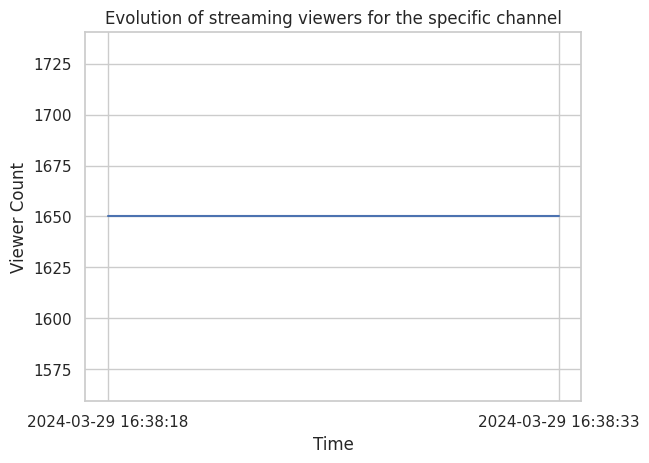

In [ ]:
# Alternatively ... :

import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Plot line plot
sns.lineplot(data=data_casinodaddy, x=data_casinodaddy.index, y="current_viewers")

# Set plot title
plt.title("Evolution of streaming viewers for the specific channel")

# Set x-axis label
plt.xlabel("Time")

# Set y-axis label
plt.ylabel("Viewer Count")

# Show plot
plt.show()

In [ ]:
# Do not forget to save the data if needed
data_casinodaddy.to_csv("casinodaddy.csv", sep=',', index=True, encoding='utf-8')
